In [1]:
import telebot
import config
import dbworker
from telebot import types
from PIL import Image

img = Image.new('RGB', (256*5, 256*5))
img1 = Image.open('grass.jpg').resize((255,255))
img2 = Image.open('infantry.jpg').resize((255,255))

class Inf:
    data = {}
    def __init__(self, pos):
        self.id = id
        self.health = 100
        self.moves = 1
        self.damage = 10
        self.range = 2
        self.pos = pos
        A[self.pos[0]][self.pos[1]] = self
        self.data[self] = id
    def wounds(self,dmg):
        if (self.health - dmg) >0:
            self.health -= dmg
        else:
            self.health = 0
    def move(self,new_pos):
        if new_pos[0]<=(len(A)-1) and new_pos[1]<=(len(A)-1):
            if (self.pos[0] - new_pos[0]) in range(-1,2) and (self.pos[1] - new_pos[1]) in range(-1,2):
                A[self.pos[0]][self.pos[1]] = 0
                self.pos = new_pos
                A[self.pos[0]][self.pos[1]] = self
                return('Отлично! Твой юнит на позиции:' + str(self.pos))
            else:
                return('Out of move range')
        else:
            return('Out of move range')
    def shoot(self, target):
        if (self.pos[0] - target[0]) in range(-(self.range),self.range+1) and (self.pos[1] - target[1]) in range(-self.range,self.range+1):
            if target[0]<=(len(A)-1) and target[1]<=(len(A)-1):
                if A[target[0]][target[1]] == 0:
                    return('Промах!')
                else:
                    A[target[0]][target[1]].wounds(self.damage)
                    if A[target[0]][target[1]].health == 0:
                        A[target[0]][target[1]] = 0
                    return('10 урона!')
            else:
                return('Промах!')
        else:
            return('Out of range')   

def map(N):
    A = []
    for i in range(N):
        A.append([0]*N)
    return A

def mapgen():
    
    for indexi,i in enumerate(A):
        for indexj,j in enumerate(i):
            if j == 0:
                img.paste(img1, (256*indexj,256*indexi))
            else:
                img.paste(img2, (256*indexj,256*indexi))
    return img

bot = telebot.TeleBot(config.token)

# Начало диалога
@bot.message_handler(commands=["start"])
def cmd_start(message):
    bot.send_message(message.chat.id, "Привет! Пришли начальную позицию своего юнита")
    bot.send_photo(message.chat.id, photo = Image.open('map.png'))
    dbworker.set_state(message.chat.id, config.States.S_ENTER_POS.value)
A = map(5)
id1 = None
id2 = None

# По команде /reset будем сбрасывать состояния, возвращаясь к началу диалога
@bot.message_handler(commands=["reset"])
def cmd_reset(message):
    bot.send_message(message.chat.id, "Что ж, начнём по-новой. Пришли начальную позицию своего юнита")
    bot.send_photo(message.chat.id, photo = Image.open('map.png'))
    dbworker.set_state(message.chat.id, config.States.S_ENTER_POS.value)
A = map(5)
id1 = None
id2 = None
    
@bot.message_handler(func=lambda message: dbworker.get_current_state(message.chat.id) == config.States.S_ENTER_POS.value)
def user_entering_pos(message):
    global id1
    global id2
    global A
    id1 = Inf([int(message.text[-3]),int(message.text[-1])])
    if int(message.text[-3]) in range(0,3):
        id2 = Inf([4,2])
    else:
        id2 = Inf([0,3])
    bot.send_photo(message.chat.id, photo = mapgen())
    bot.send_message(message.chat.id, text = 'Отлично! Юнит врага находится на позиции ' + str(id2.pos)+'!')
    markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
    btn1 = types.KeyboardButton("Пропустить фазу движения")
    markup.add(btn1)
    bot.send_message(message.chat.id, text = 'Выбери куда передвинуть своего юнита.', reply_markup=markup)
    dbworker.set_state(message.chat.id, config.States.S_ENTER_MOVE.value)
    


@bot.message_handler(func=lambda message: dbworker.get_current_state(message.chat.id) == config.States.S_ENTER_MOVE.value)
def user_entering_move(message):
    global id1
    global id2
    global A
    if(message.text == "Пропустить фазу движения"):
        bot.send_message(message.chat.id, text = 'Хорошо!', reply_markup=types.ReplyKeyboardRemove())
        btn1 = types.KeyboardButton("Пропустить фазу стрельбы")
        markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
        markup.add(btn1)
        bot.send_message(message.chat.id, text = 'Выбери куда стрелять.', reply_markup=markup)
        dbworker.set_state(message.chat.id, config.States.S_ENTER_SHOOT.value)
    else:
        id1.move([int(message.text[-3]),int(message.text[-1])])
        if id1.move([int(message.text[-3]),int(message.text[-1])]) == 'Out of move range':
            bot.send_message(message.chat.id, text = 'У юнита не хватает очков движения, выбери точку до которой он может дойти')

        else:
            bot.send_photo(message.chat.id, photo = mapgen())
            bot.send_message(message.chat.id, text = id1.move([int(message.text[-3]),int(message.text[-1])]))
            btn1 = types.KeyboardButton("Пропустить фазу стрельбы")
            markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
            markup.add(btn1)
            bot.send_message(message.chat.id, text = 'Выбери куда стрелять.', reply_markup=markup)
            dbworker.set_state(message.chat.id, config.States.S_ENTER_SHOOT.value)
@bot.message_handler(func=lambda message: dbworker.get_current_state(message.chat.id) == config.States.S_ENTER_SHOOT.value)
def user_entering_shoot(message):
    global id1
    global id2
    global A
    if(message.text == "Пропустить фазу стрельбы"):
        bot.send_message(message.chat.id, text = 'Хорошо!', reply_markup=types.ReplyKeyboardRemove())
        btn1 = types.KeyboardButton("Пропустить фазу движения")
        markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
        markup.add(btn1)
        bot.send_message(message.chat.id, text = 'Выбери куда передвинуть своего юнита.', reply_markup=markup)
        dbworker.set_state(message.chat.id, config.States.S_ENTER_MOVE.value)
    else:
        id1.shoot([int(message.text[-3]),int(message.text[-1])])
        bot.send_message(message.chat.id, text = id1.shoot([int(message.text[-3]),int(message.text[-1])]))
        btn1 = types.KeyboardButton("Пропустить фазу движения")
        markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
        markup.add(btn1)
        bot.send_message(message.chat.id, text = 'Выбери куда передвинуть своего юнита.',reply_markup=markup)
        dbworker.set_state(message.chat.id, config.States.S_ENTER_MOVE.value)
    
bot.infinity_polling()

2023-04-28 04:37:54,872 (__init__.py:966 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
2023-04-28 04:37:54,879 (__init__.py:968 MainThread) ERROR - TeleBot: "Break infinity polling"


SyntaxError: invalid syntax (<ipython-input-59-4d1b45524e13>, line 4)

In [1]:
from telebot import types

2022-12-17 00:01:41,867 (__init__.py:968 MainThread) ERROR - TeleBot: "Break infinity polling"


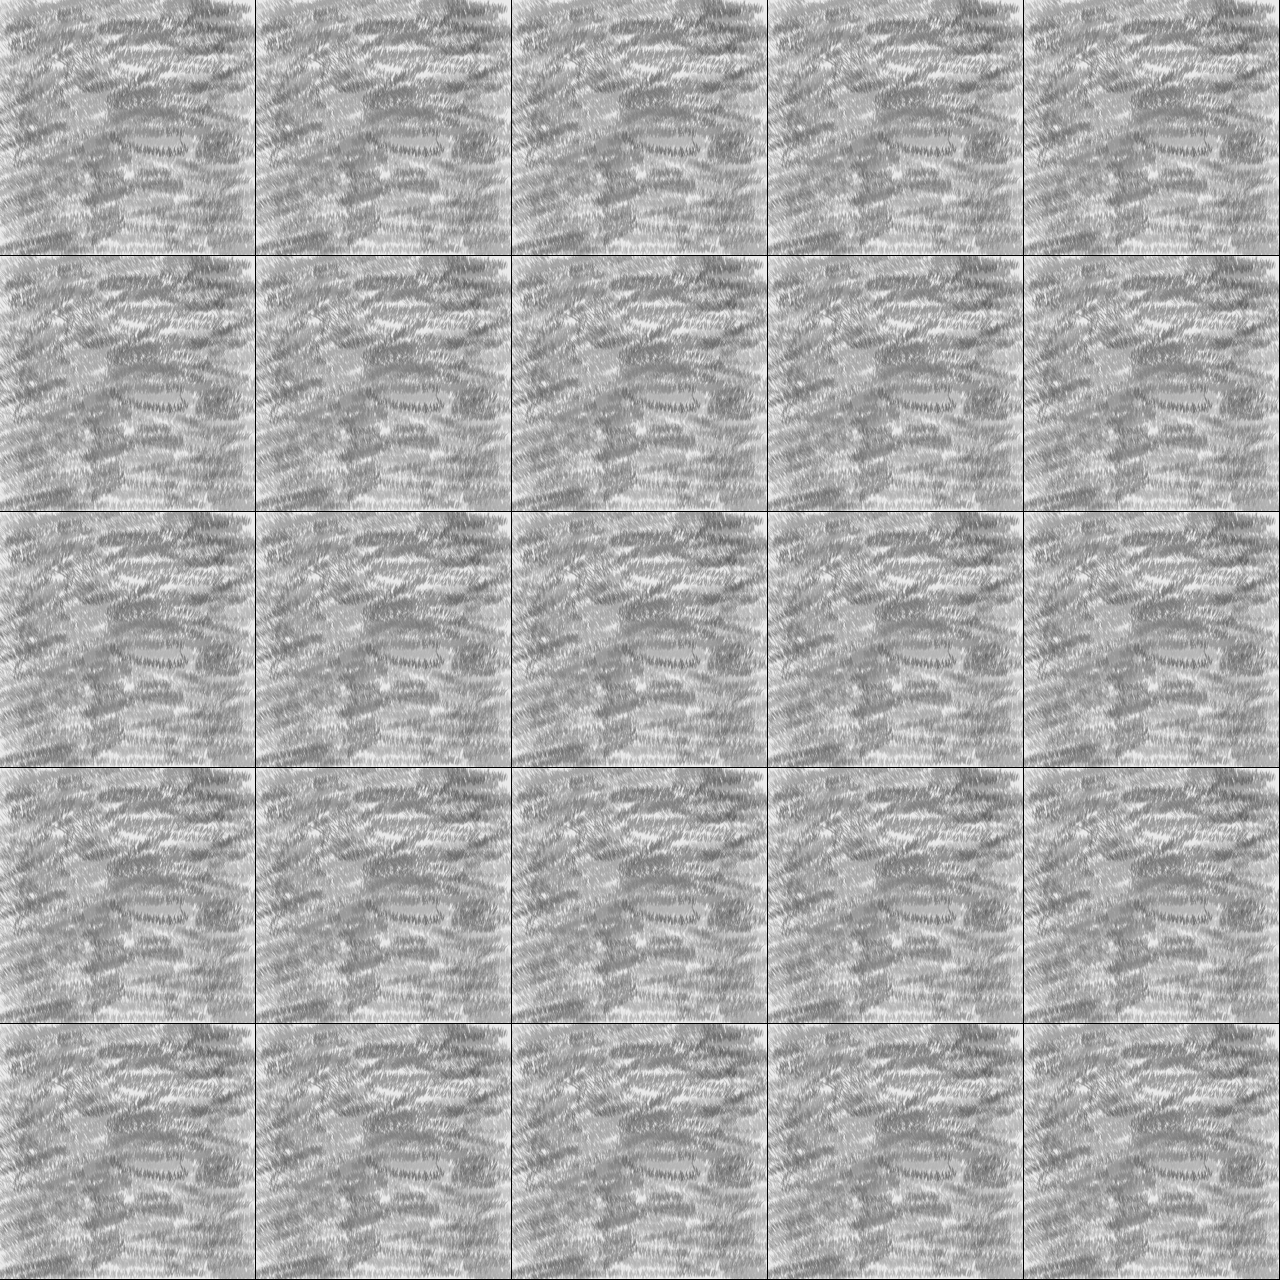

In [31]:
photo1